## Setup

In [1]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Function to set random seed
def set_random_seed(seed=42):
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
tf.reset_default_graph()
set_random_seed()

In [2]:
# Logistic function for a numpy array
def sigmoid(X):
    return 1.0 / (1.0 + np.exp(-X))

# Softmax function for a numpy array
def softmax(X, axis=-1):
    return np.exp(X) / np.sum(np.exp(X), axis=axis, keepdims=True)

## MNIST

In [3]:
# Load the MNIST dataset
(data_train, labels_train), (data_test, labels_test) = tf.keras.datasets.mnist.load_data()

# Flatten the dataset
data_train = data_train.reshape(len(data_train), -1)
data_test = data_test.reshape(len(data_test), -1)

# Scale the dataset
scaler = StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

# Create one-hot labels
binarizer = LabelBinarizer()
labels_train_one_hot = binarizer.fit_transform(labels_train)
labels_test_one_hot = binarizer.transform(labels_test)

print(data_train.shape, labels_train.shape, data_test.shape, labels_test.shape)

/home/ice-bear/anaconda3/envs/machine_learning/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(63000, 784) (63000,) (7000, 784) (7000,)


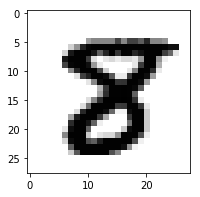

Label: 8


In [4]:
# Function to display one MNIST data
def plot_digit(x):
    plt.figure(figsize=(3,3))
    x = scaler.inverse_transform(x)
    x = x.reshape(28, 28)
    plt.imshow(x, cmap=matplotlib.cm.binary)
    plt.show()
    
plot_digit(data_train[0])
print("Label:", labels_train[0])

In [5]:
# Generator to fetch the dataset one batch at a time
def fetch_batch(X, y, batch_size):
    shuffled_indices = np.random.permutation(len(X))
    for i in range(0, len(X), batch_size):
        X_batch = X[shuffled_indices[i:i+batch_size]]
        y_batch = y[shuffled_indices[i:i+batch_size]]
        yield X_batch, y_batch

## LeNet-5

In [6]:
class LeNet5:
    def __init__(self, dropout_rate=0.5, learning_rate=0.1, momentum=0.5, graph_seed=42):
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.graph_seed = graph_seed
        
    def build_graph(self):
        # MNIST properties
        height = 28
        width = 28
        channels = 1
        input_size = height * width * channels
        output_size = 10
        
        # Build the graph
        self.graph = tf.Graph()
        with self.graph.as_default():
            # Set graph-level random seed
            tf.set_random_seed(self.graph_seed)
            
            # Make input placeholders
            self.X_ph = tf.placeholder(shape=(None, input_size), dtype=tf.float32)
            self.y_ph = tf.placeholder(shape=(None,), dtype=tf.int32)
            self.train_ph = tf.placeholder(shape=(), dtype=tf.bool)
            
            # First convolutional layer
            X_reshaped = tf.reshape(self.X_ph, shape=(-1, height, width, channels))
            X = tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='SAME', 
                                       activation=tf.nn.tanh)(X_reshaped)
            
            # First pooling layer
            X = tf.nn.avg_pool(X, ksize=(1,2,2,1), strides=(1,2,2,1), padding='VALID')
            
            # Second convolutional layer
            X = tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='VALID', 
                                       activation=tf.nn.tanh)(X)
            
            # Second pooling layer
            X = tf.nn.avg_pool(X, ksize=(1,2,2,1), strides=(1,2,2,1), padding='VALID')
            
            # Third convolutional layer
            X = tf.keras.layers.Conv2D(filters=120, kernel_size=5, strides=1, padding='VALID', 
                                       activation=tf.nn.tanh)(X)
            
            # Fully connected layers
            X = tf.reshape(X, shape=(-1, 120))
            X = tf.keras.layers.Dropout(self.dropout_rate)(X, training=self.train_ph)
            X = tf.keras.layers.Dense(units=84, activation=tf.nn.tanh)(X)
            X = tf.keras.layers.Dropout(self.dropout_rate)(X, training=self.train_ph)
            self.logits = tf.keras.layers.Dense(units=output_size)(X)
            
            # Probabilities for each class
            self.probs = tf.nn.softmax(self.logits, axis=1)
            
            # Use mean cross entropy as the loss function
            cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.y_ph)
            self.loss = tf.reduce_mean(cross_entropy)
            
            # Make optimizer and training operation
            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=self.momentum)
            self.train_op = optimizer.minimize(self.loss)
            
            # Variables initializer
            self.init = tf.global_variables_initializer()
            
        # Create a session and initialize all variables
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.init)
            
        return self.graph
            
    def train(self, X, y, batch_size=100, n_epochs=1):
        for epoch in range(n_epochs):
            # Perform mini-batch gradient descent using the entire dataset
            for X_batch, y_batch in fetch_batch(X, y, batch_size):
                self.sess.run(self.train_op, feed_dict={self.X_ph: X_batch, 
                                                        self.y_ph: y_batch, 
                                                        self.train_ph: True})
                
    def predict(self, X):
        # Return the prediction, a number between 0-9, for each row of X
        logits = self.sess.run(self.logits, feed_dict={self.X_ph: X, self.train_ph: False})
        return np.argmax(logits, axis=1)
        
    def get_probs(self, X):
        # Return the estimated probabilities of all ten classes, for each row of X
        probs = self.sess.run(self.probs, feed_dict={self.X_ph: X, self.train_ph: False})
        return probs
    
    def reset_session(self):
        # Reset the session and initialize all variables
        self.sess.close()
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.init)
            
    def __del__(self):
        self.sess.close()

In [7]:
set_random_seed(42)

lenet5 = LeNet5(dropout_rate=0.5, learning_rate=0.01, momentum=0.9)

lenet5.build_graph()

n_epochs = 50
for epoch in range(n_epochs):
    lenet5.train(data_train, labels_train)
    prediction = lenet5.predict(data_test)
    print("Epoch: %d \t Test accuracy: %.4f" % (epoch, sum(prediction==labels_test) / len(labels_test)))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch: 0 	 Test accuracy: 0.9399
Epoch: 1 	 Test accuracy: 0.9649
Epoch: 2 	 Test accuracy: 0.9733
Epoch: 3 	 Test accuracy: 0.9784
Epoch: 4 	 Test accuracy: 0.9791
Epoch: 5 	 Test accuracy: 0.9816
Epoch: 6 	 Test accuracy: 0.9819
Epoch: 7 	 Test accuracy: 0.9834
Epoch: 8 	 Test accuracy: 0.9849
Epoch: 9 	 Test accuracy: 0.9844
Epoch: 10 	 Test accuracy: 0.9869
Epoch: 11 	 Test accuracy: 0.9859
Epoch: 12 	 Test accuracy: 0.9851
Epoch: 13 	 Test accuracy: 0.9871
Epoch: 14 	 Test accuracy: 0.9863
Epoch: 15 	 Test accuracy: 0.9856
Epoch: 16 	 Test accuracy: 0.9873
Epoch: 17 	 Test accuracy: 0.9877
Epoch: 18 	 Test accuracy: 0.9889
Epoch: 19 	 Test accuracy: 0.9873
Epoch: 20 	 Test accuracy: 0.9879
Epoch: 21 	 Test accuracy: 0.9886
Epoch: 22 	 Test accuracy: 0.9889
Epoch: 23 	 Test accuracy: 0.9886
Epoch: 

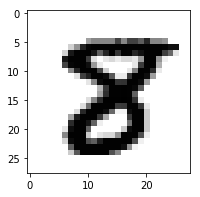

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


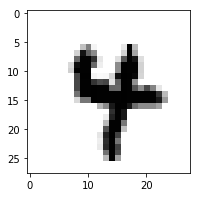

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


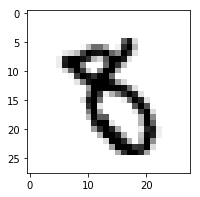

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


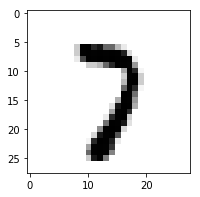

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


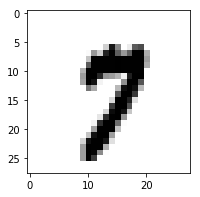

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [8]:
# Use the trained CNN to generate target probabilities
cnn_probs = lenet5.get_probs(data_train)

# Show some examples to make sure everything's okay
for i in range(5):
    plot_digit(data_train[i])
    print(np.around(cnn_probs[i],2))

In [ ]:
# Save the soft targets in a file
np.save("soft_targets.npy", cnn_probs)

## Soft Decision Tree

In [9]:
class SoftDecisionTree:
    def __init__(self, max_depth=8, inverse_temperature=1.0, reg_fn=lambda d: 2 ** -d, 
                 learning_rate=0.1, epsilon=1e-10, graph_seed=42):
        self.max_depth = max_depth
        self.inverse_temperature = inverse_temperature
        self.reg_fn = reg_fn
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.graph_seed = graph_seed
    
    def build_graph(self):
        # MNIST properties
        input_size = 28 * 28
        output_size = 10
        
        # Create lists for storing variables
        n_nodes = 2 ** (self.max_depth + 1)
        self.weights = [0] * n_nodes
        self.bias = [0] * n_nodes
        self.leaf_logits = [0] * n_nodes
        self.path_probs = [0] * n_nodes
        
        # Build the graph
        self.graph = tf.Graph()
        with self.graph.as_default():
            # Set graph-level random seed
            tf.set_random_seed(self.graph_seed)
            
            # Make input placeholders
            self.X_ph = tf.placeholder(shape=(None, input_size), dtype=tf.float32)
            self.y_ph = tf.placeholder(shape=(None, output_size), dtype=tf.float32)
            
            # Initialize the loss function
            self.loss = 0
            
            # Start building from the root node
            batch_size = tf.shape(self.X_ph)[0]
            self.path_probs[1] = tf.fill([batch_size], 1.0)
            self.build_node(self.X_ph, self.y_ph)
            
            # Make optimizer and training operation
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            self.train_op = optimizer.minimize(self.loss)
            
            # Variables initializer
            self.init = tf.global_variables_initializer()
            
        # Create a session and initialize all variables
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.init)
            
        return self.graph
    
    def build_node(self, X, y, current_depth=1, index=1):
        if current_depth == self.max_depth:
            # Build a leaf node
            self.leaf_logits[index] = tf.Variable(initial_value=np.random.randn(y.shape[1], 1), dtype=tf.float32)
            
            # Class distribution at this leaf node
            probs = tf.nn.softmax(self.leaf_logits[index], axis=0)
            
            # Compute loss at this leaf node
            cross_entropy = tf.squeeze(tf.matmul(y, -tf.log(probs)), axis=1)
            weighted_cross_entropy = tf.multiply(self.path_probs[index], cross_entropy)
            
            self.loss = self.loss + tf.reduce_mean(weighted_cross_entropy)
        else:
            # Build an internal node
            self.weights[index] = tf.Variable(initial_value=np.random.randn(X.shape[1], 1), dtype=tf.float32)
            self.bias[index] = tf.Variable(initial_value=0.0)
            
            # Use sigmoid to determine, for each data, the probability of going to the right child node
            mul = tf.matmul(X, self.weights[index]) + self.bias[index]
            probs = tf.squeeze(tf.sigmoid(self.inverse_temperature * mul), axis=1)
            
            # Compute path probabilities of left and right child nodes
            left_index = 2 * index
            right_index = 2 * index + 1
            self.path_probs[left_index] = tf.multiply(self.path_probs[index], 1-probs)
            self.path_probs[right_index] = tf.multiply(self.path_probs[index], probs)
            
            # Regularization term
            reg_strength = self.reg_fn(current_depth)
            left_ratio = tf.reduce_sum(self.path_probs[left_index]) / (tf.reduce_sum(self.path_probs[index]) + self.epsilon)
            right_ratio = tf.reduce_sum(self.path_probs[right_index]) / (tf.reduce_sum(self.path_probs[index]) + self.epsilon)
            
            self.loss = self.loss - reg_strength * (0.5 * tf.log(left_ratio + self.epsilon) + 0.5 * tf.log(right_ratio + self.epsilon))
            
            # Build left and right subtrees
            self.build_node(X, y, current_depth+1, left_index)
            self.build_node(X, y, current_depth+1, right_index)
            
    def train(self, X, y, batch_size=100, n_epochs=1):
        for epoch in range(n_epochs):
            # Perform mini-batch gradient descent using the entire dataset
            for X_batch, y_batch in fetch_batch(X, y, batch_size):
                if len(X_batch) < batch_size: continue  # skip last batch if it is small
                self.sess.run(self.train_op, feed_dict={self.X_ph: X_batch, self.y_ph: y_batch})
                   
    def get_logits(self, X, current_depth=1, index=1):
        if len(X) == 0:
            # If there's no sample, return nothing
            return None
        elif current_depth == self.max_depth:
            # At leaf node: simply return the logits for every sample that ends up here
            logits = self.sess.run(self.leaf_logits[index])
            logits = logits.ravel()
            return [logits for _ in range(len(X))]
        else:
            # At internal node: split the dataset, get the logits of each, and then combine them
            weights, bias = self.sess.run([self.weights[index], self.bias[index]])
            
            mul = np.dot(X, weights) + bias
            probs = np.squeeze(sigmoid(self.inverse_temperature * mul), axis=1)
            
            mask = np.array(probs < 0.5)
            
            indices_left = np.nonzero(mask)
            indices_right = np.nonzero(np.logical_not(mask))
            
            logits_left = self.get_logits(X[indices_left], current_depth+1, index*2)
            logits_right = self.get_logits(X[indices_right], current_depth+1, index*2+1)
            
            logits = []
            it_left, it_right = 0, 0
            for m in mask:
                if m:
                    logits.append(logits_left[it_left])
                    it_left += 1
                else:
                    logits.append(logits_right[it_right])
                    it_right += 1
            
            return logits
    
    def get_probs_global(self, X, path_probs, current_depth=1, index=1):
        if current_depth == self.max_depth:
            # At leaf node: return class distribution at this leaf node
            logits = self.sess.run(self.leaf_logits[index])
            probs = softmax(logits, axis=0)
            distrib = np.dot(path_probs.reshape(-1, 1), probs.reshape(1, -1))
            return distrib
        else:
            # At internal node: get the probabilities from both child nodes and add them together
            weights, bias = self.sess.run([self.weights[index], self.bias[index]])
            
            mul = np.dot(X, weights) + bias
            probs = np.squeeze(sigmoid(self.inverse_temperature * mul), axis=1)
            
            path_probs_left = np.multiply(path_probs, 1-probs)
            path_probs_right = np.multiply(path_probs, probs)
            
            probs_left = self.get_probs_global(X, path_probs_left, current_depth+1, index*2)
            probs_right = self.get_probs_global(X, path_probs_right, current_depth+1, index*2+1)
            
            return probs_left + probs_right
    
    def predict(self, X, method=2):
        if method == 1:
            logits = self.get_logits(X)
            return np.argmax(logits, axis=1)
        elif method == 2:
            root_probs = np.full((len(X)), 1.0)
            probs = self.get_probs_global(X, root_probs)
            return np.argmax(probs, axis=1)
        else:
            raise NotImplementedError
        
    def get_probs(self, X, method=2):
        if method == 1:
            logits = self.get_logits(X)
            return softmax(logits, axis=1)
        elif method == 2:
            root_probs = np.full((len(X)), 1.0)
            probs = self.get_probs_global(X, root_probs)
            return probs
        else:
            raise NotImplementedError
        
    def compute_loss(self, X, y):
        return self.sess.run(self.loss, feed_dict={self.X_ph: X, self.y_ph: y})
    
    def reset_session(self):
        if self.sess:
            self.sess.close()
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.init)
            
    def __del__(self):
        if self.sess:
            self.sess.close()

In [ ]:
# Load soft targets
cnn_probs = np.load("soft_targets.npy")

In [10]:
# Measure performance of the model using the hard data and with default hyperparameters

set_random_seed(42)
t = time.time()

tree = SoftDecisionTree()

tree.build_graph()

n_epochs = 50
for epoch in range(n_epochs):
    tree.train(data_train, labels_train_one_hot, batch_size=256)
    
    # Compute training accuracy
    prediction = tree.predict(data_train, method=2)
    train_accuracy = sum(prediction == labels_train) / len(prediction)

    # Compute test accuracy
    prediction = tree.predict(data_test, method=2)
    test_accuracy = sum(prediction == labels_test) / len(prediction)

    # Compute loss
    loss = tree.compute_loss(data_test, labels_test_one_hot)

    print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
          (epoch, train_accuracy, test_accuracy, loss))

Epoch: 0 	 Train accuracy: 0.681 	 Test accuracy: 0.678 	 Loss: 3.575

Epoch: 1 	 Train accuracy: 0.700 	 Test accuracy: 0.706 	 Loss: 3.458

Epoch: 2 	 Train accuracy: 0.731 	 Test accuracy: 0.736 	 Loss: 3.412

Epoch: 3 	 Train accuracy: 0.720 	 Test accuracy: 0.720 	 Loss: 3.412

Epoch: 4 	 Train accuracy: 0.752 	 Test accuracy: 0.752 	 Loss: 3.337

Epoch: 5 	 Train accuracy: 0.720 	 Test accuracy: 0.724 	 Loss: 3.361

Epoch: 6 	 Train accuracy: 0.726 	 Test accuracy: 0.734 	 Loss: 3.357

Epoch: 7 	 Train accuracy: 0.725 	 Test accuracy: 0.731 	 Loss: 3.363

Epoch: 8 	 Train accuracy: 0.719 	 Test accuracy: 0.713 	 Loss: 3.418

Epoch: 9 	 Train accuracy: 0.754 	 Test accuracy: 0.761 	 Loss: 3.296

Epoch: 10 	 Train accuracy: 0.749 	 Test accuracy: 0.753 	 Loss: 3.283

Epoch: 11 	 Train accuracy: 0.752 	 Test accuracy: 0.757 	 Loss: 3.268

Epoch: 12 	 Train accuracy: 0.741 	 Test accuracy: 0.743 	 Loss: 3.298

Epoch: 13 	 Train accuracy: 0.744 	 Test accuracy: 0.736 	 Loss: 3.292

Ep

In [11]:
# Measure performance of the model using the soft data and with default hyperparameters

set_random_seed(42)
t = time.time()

tree = SoftDecisionTree()

tree.build_graph()

n_epochs = 50
for epoch in range(n_epochs):
    tree.train(data_train, cnn_probs, batch_size=256)
    
    # Compute training accuracy
    prediction = tree.predict(data_train, method=2)
    train_accuracy = sum(prediction == labels_train) / len(prediction)

    # Compute test accuracy
    prediction = tree.predict(data_test, method=2)
    test_accuracy = sum(prediction == labels_test) / len(prediction)

    # Compute loss
    loss = tree.compute_loss(data_test, labels_test_one_hot)

    print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
          (epoch, train_accuracy, test_accuracy, loss))

Epoch: 0 	 Train accuracy: 0.642 	 Test accuracy: 0.632 	 Loss: 3.653

Epoch: 1 	 Train accuracy: 0.707 	 Test accuracy: 0.706 	 Loss: 3.466

Epoch: 2 	 Train accuracy: 0.723 	 Test accuracy: 0.736 	 Loss: 3.396

Epoch: 3 	 Train accuracy: 0.737 	 Test accuracy: 0.735 	 Loss: 3.380

Epoch: 4 	 Train accuracy: 0.710 	 Test accuracy: 0.711 	 Loss: 3.411

Epoch: 5 	 Train accuracy: 0.700 	 Test accuracy: 0.696 	 Loss: 3.450

Epoch: 6 	 Train accuracy: 0.708 	 Test accuracy: 0.706 	 Loss: 3.412

Epoch: 7 	 Train accuracy: 0.698 	 Test accuracy: 0.692 	 Loss: 3.426

Epoch: 8 	 Train accuracy: 0.718 	 Test accuracy: 0.720 	 Loss: 3.402

Epoch: 9 	 Train accuracy: 0.723 	 Test accuracy: 0.721 	 Loss: 3.386

Epoch: 10 	 Train accuracy: 0.718 	 Test accuracy: 0.718 	 Loss: 3.359

Epoch: 11 	 Train accuracy: 0.737 	 Test accuracy: 0.739 	 Loss: 3.338

Epoch: 12 	 Train accuracy: 0.733 	 Test accuracy: 0.733 	 Loss: 3.337

Epoch: 13 	 Train accuracy: 0.742 	 Test accuracy: 0.737 	 Loss: 3.344

Ep

In [12]:
# Test the model using the hard data and with better hyperparameters

set_random_seed(42)
t = time.time()

tree = SoftDecisionTree(max_depth = 8,
                        inverse_temperature = 0.1,
                        reg_fn = lambda d: 4 ** -d,
                        learning_rate = 0.01)

tree.build_graph()

n_epochs = 50
for epoch in range(n_epochs):
    tree.train(data_train, labels_train_one_hot, batch_size=256)
    
    # Compute training accuracy
    prediction = tree.predict(data_train, method=2)
    train_accuracy = sum(prediction == labels_train) / len(prediction)

    # Compute test accuracy
    prediction = tree.predict(data_test, method=2)
    test_accuracy = sum(prediction == labels_test) / len(prediction)

    # Compute loss
    loss = tree.compute_loss(data_test, labels_test_one_hot)

    print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
          (epoch, train_accuracy, test_accuracy, loss))

Epoch: 0 	 Train accuracy: 0.909 	 Test accuracy: 0.908 	 Loss: 0.962

Epoch: 1 	 Train accuracy: 0.938 	 Test accuracy: 0.934 	 Loss: 0.795

Epoch: 2 	 Train accuracy: 0.951 	 Test accuracy: 0.943 	 Loss: 0.729

Epoch: 3 	 Train accuracy: 0.958 	 Test accuracy: 0.946 	 Loss: 0.693

Epoch: 4 	 Train accuracy: 0.963 	 Test accuracy: 0.950 	 Loss: 0.671

Epoch: 5 	 Train accuracy: 0.966 	 Test accuracy: 0.953 	 Loss: 0.654

Epoch: 6 	 Train accuracy: 0.969 	 Test accuracy: 0.953 	 Loss: 0.644

Epoch: 7 	 Train accuracy: 0.970 	 Test accuracy: 0.953 	 Loss: 0.635

Epoch: 8 	 Train accuracy: 0.972 	 Test accuracy: 0.956 	 Loss: 0.630

Epoch: 9 	 Train accuracy: 0.974 	 Test accuracy: 0.955 	 Loss: 0.628

Epoch: 10 	 Train accuracy: 0.975 	 Test accuracy: 0.955 	 Loss: 0.624

Epoch: 11 	 Train accuracy: 0.977 	 Test accuracy: 0.956 	 Loss: 0.623

Epoch: 12 	 Train accuracy: 0.978 	 Test accuracy: 0.957 	 Loss: 0.620

Epoch: 13 	 Train accuracy: 0.979 	 Test accuracy: 0.956 	 Loss: 0.622

Ep

In [13]:
# Test the model using the soft data and with better hyperparameters

set_random_seed(42)
t = time.time()

tree = SoftDecisionTree(max_depth = 8,
                        inverse_temperature = 0.1,
                        reg_fn = lambda d: 4 ** -d,
                        learning_rate = 0.01)

tree.build_graph()

n_epochs = 50
for epoch in range(n_epochs):
    tree.train(data_train, cnn_probs, batch_size=256)
    
    # Compute training accuracy
    prediction = tree.predict(data_train, method=2)
    train_accuracy = sum(prediction == labels_train) / len(prediction)

    # Compute test accuracy
    prediction = tree.predict(data_test, method=2)
    test_accuracy = sum(prediction == labels_test) / len(prediction)

    # Compute loss
    loss = tree.compute_loss(data_test, labels_test_one_hot)

    print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
          (epoch, train_accuracy, test_accuracy, loss))

Epoch: 0 	 Train accuracy: 0.910 	 Test accuracy: 0.908 	 Loss: 0.960

Epoch: 1 	 Train accuracy: 0.939 	 Test accuracy: 0.935 	 Loss: 0.793

Epoch: 2 	 Train accuracy: 0.951 	 Test accuracy: 0.943 	 Loss: 0.727

Epoch: 3 	 Train accuracy: 0.958 	 Test accuracy: 0.948 	 Loss: 0.691

Epoch: 4 	 Train accuracy: 0.962 	 Test accuracy: 0.950 	 Loss: 0.670

Epoch: 5 	 Train accuracy: 0.966 	 Test accuracy: 0.951 	 Loss: 0.653

Epoch: 6 	 Train accuracy: 0.968 	 Test accuracy: 0.954 	 Loss: 0.642

Epoch: 7 	 Train accuracy: 0.970 	 Test accuracy: 0.954 	 Loss: 0.633

Epoch: 8 	 Train accuracy: 0.972 	 Test accuracy: 0.955 	 Loss: 0.629

Epoch: 9 	 Train accuracy: 0.973 	 Test accuracy: 0.954 	 Loss: 0.629

Epoch: 10 	 Train accuracy: 0.975 	 Test accuracy: 0.956 	 Loss: 0.623

Epoch: 11 	 Train accuracy: 0.976 	 Test accuracy: 0.956 	 Loss: 0.622

Epoch: 12 	 Train accuracy: 0.977 	 Test accuracy: 0.957 	 Loss: 0.619

Epoch: 13 	 Train accuracy: 0.978 	 Test accuracy: 0.958 	 Loss: 0.619

Ep

In [14]:
# Try various depths

for depth in [6, 7, 8, 9, 10]:
    print("Using cnn data, depth = %d" % (depth))
    
    set_random_seed(42)
    
    tree = SoftDecisionTree(max_depth = depth,
                            inverse_temperature = 0.1,
                            reg_fn = lambda d: 4 ** -d,
                            learning_rate = 0.01)
    
    tree.build_graph()
    
    n_epochs = 30
    for epoch in range(n_epochs):
        tree.train(data_train, cnn_probs, batch_size=256)

        # Compute training accuracy
        prediction = tree.predict(data_train, method=2)
        train_accuracy = sum(prediction == labels_train) / len(prediction)

        # Compute test accuracy
        prediction = tree.predict(data_test, method=2)
        test_accuracy = sum(prediction == labels_test) / len(prediction)

        # Compute loss
        loss = tree.compute_loss(data_test, labels_test_one_hot)

        print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
              (epoch, train_accuracy, test_accuracy, loss))

Using cnn data, depth = 6
Epoch: 0 	 Train accuracy: 0.879 	 Test accuracy: 0.876 	 Loss: 1.097

Epoch: 1 	 Train accuracy: 0.915 	 Test accuracy: 0.908 	 Loss: 0.899

Epoch: 2 	 Train accuracy: 0.924 	 Test accuracy: 0.918 	 Loss: 0.827

Epoch: 3 	 Train accuracy: 0.931 	 Test accuracy: 0.920 	 Loss: 0.790

Epoch: 4 	 Train accuracy: 0.934 	 Test accuracy: 0.924 	 Loss: 0.770

Epoch: 5 	 Train accuracy: 0.937 	 Test accuracy: 0.927 	 Loss: 0.755

Epoch: 6 	 Train accuracy: 0.939 	 Test accuracy: 0.927 	 Loss: 0.745

Epoch: 7 	 Train accuracy: 0.942 	 Test accuracy: 0.930 	 Loss: 0.736

Epoch: 8 	 Train accuracy: 0.943 	 Test accuracy: 0.929 	 Loss: 0.731

Epoch: 9 	 Train accuracy: 0.945 	 Test accuracy: 0.931 	 Loss: 0.726

Epoch: 10 	 Train accuracy: 0.946 	 Test accuracy: 0.929 	 Loss: 0.722

Epoch: 11 	 Train accuracy: 0.947 	 Test accuracy: 0.931 	 Loss: 0.719

Epoch: 12 	 Train accuracy: 0.948 	 Test accuracy: 0.932 	 Loss: 0.717

Epoch: 13 	 Train accuracy: 0.948 	 Test accurac

Epoch: 23 	 Train accuracy: 0.989 	 Test accuracy: 0.963 	 Loss: 0.595

Epoch: 24 	 Train accuracy: 0.989 	 Test accuracy: 0.963 	 Loss: 0.597

Epoch: 25 	 Train accuracy: 0.990 	 Test accuracy: 0.965 	 Loss: 0.597

Epoch: 26 	 Train accuracy: 0.990 	 Test accuracy: 0.964 	 Loss: 0.599

Epoch: 27 	 Train accuracy: 0.990 	 Test accuracy: 0.965 	 Loss: 0.598

Epoch: 28 	 Train accuracy: 0.990 	 Test accuracy: 0.964 	 Loss: 0.600

Epoch: 29 	 Train accuracy: 0.990 	 Test accuracy: 0.964 	 Loss: 0.600

Using cnn data, depth = 10
Epoch: 0 	 Train accuracy: 0.924 	 Test accuracy: 0.926 	 Loss: 0.884

Epoch: 1 	 Train accuracy: 0.949 	 Test accuracy: 0.946 	 Loss: 0.734

Epoch: 2 	 Train accuracy: 0.960 	 Test accuracy: 0.952 	 Loss: 0.677

Epoch: 3 	 Train accuracy: 0.967 	 Test accuracy: 0.956 	 Loss: 0.645

Epoch: 4 	 Train accuracy: 0.972 	 Test accuracy: 0.960 	 Loss: 0.627

Epoch: 5 	 Train accuracy: 0.977 	 Test accuracy: 0.961 	 Loss: 0.614

Epoch: 6 	 Train accuracy: 0.980 	 Test acc

In [15]:
# Try various inverse_temperature

for temperature in [0.01, 0.05, 0.1, 0.2, 0.4]:
    print("Using cnn data, temperature = %.2f" % (temperature))
    
    set_random_seed(42)
    
    tree = SoftDecisionTree(max_depth = 8,
                            inverse_temperature = temperature,
                            reg_fn = lambda d: 4 ** -d,
                            learning_rate = 0.01)
    
    tree.build_graph()
    
    n_epochs = 30
    for epoch in range(n_epochs):
        tree.train(data_train, cnn_probs, batch_size=256)

        # Compute training accuracy
        prediction = tree.predict(data_train, method=2)
        train_accuracy = sum(prediction == labels_train) / len(prediction)

        # Compute test accuracy
        prediction = tree.predict(data_test, method=2)
        test_accuracy = sum(prediction == labels_test) / len(prediction)

        # Compute loss
        loss = tree.compute_loss(data_test, labels_test_one_hot)

        print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
              (epoch, train_accuracy, test_accuracy, loss))

Using cnn data, temperature = 0.01
Epoch: 0 	 Train accuracy: 0.741 	 Test accuracy: 0.735 	 Loss: 1.763

Epoch: 1 	 Train accuracy: 0.867 	 Test accuracy: 0.867 	 Loss: 1.326

Epoch: 2 	 Train accuracy: 0.900 	 Test accuracy: 0.899 	 Loss: 1.130

Epoch: 3 	 Train accuracy: 0.915 	 Test accuracy: 0.913 	 Loss: 1.022

Epoch: 4 	 Train accuracy: 0.924 	 Test accuracy: 0.924 	 Loss: 0.953

Epoch: 5 	 Train accuracy: 0.931 	 Test accuracy: 0.928 	 Loss: 0.902

Epoch: 6 	 Train accuracy: 0.936 	 Test accuracy: 0.932 	 Loss: 0.864

Epoch: 7 	 Train accuracy: 0.940 	 Test accuracy: 0.935 	 Loss: 0.834

Epoch: 8 	 Train accuracy: 0.943 	 Test accuracy: 0.938 	 Loss: 0.810

Epoch: 9 	 Train accuracy: 0.945 	 Test accuracy: 0.940 	 Loss: 0.790

Epoch: 10 	 Train accuracy: 0.948 	 Test accuracy: 0.942 	 Loss: 0.773

Epoch: 11 	 Train accuracy: 0.949 	 Test accuracy: 0.944 	 Loss: 0.759

Epoch: 12 	 Train accuracy: 0.951 	 Test accuracy: 0.946 	 Loss: 0.746

Epoch: 13 	 Train accuracy: 0.953 	 Tes

Epoch: 23 	 Train accuracy: 0.982 	 Test accuracy: 0.952 	 Loss: 0.641

Epoch: 24 	 Train accuracy: 0.983 	 Test accuracy: 0.951 	 Loss: 0.641

Epoch: 25 	 Train accuracy: 0.983 	 Test accuracy: 0.951 	 Loss: 0.642

Epoch: 26 	 Train accuracy: 0.983 	 Test accuracy: 0.951 	 Loss: 0.645

Epoch: 27 	 Train accuracy: 0.983 	 Test accuracy: 0.951 	 Loss: 0.645

Epoch: 28 	 Train accuracy: 0.983 	 Test accuracy: 0.952 	 Loss: 0.648

Epoch: 29 	 Train accuracy: 0.984 	 Test accuracy: 0.951 	 Loss: 0.647

Using cnn data, temperature = 0.40
Epoch: 0 	 Train accuracy: 0.867 	 Test accuracy: 0.863 	 Loss: 1.003

Epoch: 1 	 Train accuracy: 0.912 	 Test accuracy: 0.901 	 Loss: 0.822

Epoch: 2 	 Train accuracy: 0.930 	 Test accuracy: 0.915 	 Loss: 0.758

Epoch: 3 	 Train accuracy: 0.939 	 Test accuracy: 0.921 	 Loss: 0.729

Epoch: 4 	 Train accuracy: 0.947 	 Test accuracy: 0.928 	 Loss: 0.706

Epoch: 5 	 Train accuracy: 0.953 	 Test accuracy: 0.935 	 Loss: 0.684

Epoch: 6 	 Train accuracy: 0.957 	 

In [16]:
# Try various regularization strengths

for strength in [3.0, 3.5, 4.0, 4.5, 5.0]:
    print("Using cnn data, strength = %.1f" % (strength))
    
    set_random_seed(42)
    
    tree = SoftDecisionTree(max_depth = 8,
                            inverse_temperature = 0.1,
                            reg_fn = lambda d: strength ** -d,
                            learning_rate = 0.01)
    
    tree.build_graph()
    
    n_epochs = 30
    for epoch in range(n_epochs):
        tree.train(data_train, cnn_probs, batch_size=256)

        # Compute training accuracy
        prediction = tree.predict(data_train, method=2)
        train_accuracy = sum(prediction == labels_train) / len(prediction)

        # Compute test accuracy
        prediction = tree.predict(data_test, method=2)
        test_accuracy = sum(prediction == labels_test) / len(prediction)

        # Compute loss
        loss = tree.compute_loss(data_test, labels_test_one_hot)

        print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
              (epoch, train_accuracy, test_accuracy, loss))

Using cnn data, strength = 3.0
Epoch: 0 	 Train accuracy: 0.914 	 Test accuracy: 0.911 	 Loss: 1.317

Epoch: 1 	 Train accuracy: 0.940 	 Test accuracy: 0.937 	 Loss: 1.140

Epoch: 2 	 Train accuracy: 0.951 	 Test accuracy: 0.943 	 Loss: 1.067

Epoch: 3 	 Train accuracy: 0.959 	 Test accuracy: 0.949 	 Loss: 1.026

Epoch: 4 	 Train accuracy: 0.963 	 Test accuracy: 0.951 	 Loss: 1.000

Epoch: 5 	 Train accuracy: 0.966 	 Test accuracy: 0.953 	 Loss: 0.984

Epoch: 6 	 Train accuracy: 0.969 	 Test accuracy: 0.953 	 Loss: 0.974

Epoch: 7 	 Train accuracy: 0.971 	 Test accuracy: 0.955 	 Loss: 0.964

Epoch: 8 	 Train accuracy: 0.972 	 Test accuracy: 0.957 	 Loss: 0.958

Epoch: 9 	 Train accuracy: 0.973 	 Test accuracy: 0.955 	 Loss: 0.957

Epoch: 10 	 Train accuracy: 0.974 	 Test accuracy: 0.957 	 Loss: 0.953

Epoch: 11 	 Train accuracy: 0.975 	 Test accuracy: 0.957 	 Loss: 0.950

Epoch: 12 	 Train accuracy: 0.976 	 Test accuracy: 0.957 	 Loss: 0.948

Epoch: 13 	 Train accuracy: 0.977 	 Test ac

Epoch: 23 	 Train accuracy: 0.983 	 Test accuracy: 0.955 	 Loss: 0.558

Epoch: 24 	 Train accuracy: 0.983 	 Test accuracy: 0.955 	 Loss: 0.558

Epoch: 25 	 Train accuracy: 0.984 	 Test accuracy: 0.954 	 Loss: 0.558

Epoch: 26 	 Train accuracy: 0.984 	 Test accuracy: 0.955 	 Loss: 0.560

Epoch: 27 	 Train accuracy: 0.984 	 Test accuracy: 0.955 	 Loss: 0.560

Epoch: 28 	 Train accuracy: 0.984 	 Test accuracy: 0.955 	 Loss: 0.563

Epoch: 29 	 Train accuracy: 0.984 	 Test accuracy: 0.955 	 Loss: 0.565

Using cnn data, strength = 5.0
Epoch: 0 	 Train accuracy: 0.910 	 Test accuracy: 0.908 	 Loss: 0.835

Epoch: 1 	 Train accuracy: 0.938 	 Test accuracy: 0.933 	 Loss: 0.667

Epoch: 2 	 Train accuracy: 0.950 	 Test accuracy: 0.943 	 Loss: 0.604

Epoch: 3 	 Train accuracy: 0.956 	 Test accuracy: 0.947 	 Loss: 0.571

Epoch: 4 	 Train accuracy: 0.961 	 Test accuracy: 0.949 	 Loss: 0.551

Epoch: 5 	 Train accuracy: 0.964 	 Test accuracy: 0.950 	 Loss: 0.536

Epoch: 6 	 Train accuracy: 0.966 	 Test

In [17]:
# Try various learning rates

for rate in [0.001, 0.005, 0.01, 0.02, 0.05]:
    print("Using cnn data, learning rate = %.3f" % (rate))
    
    set_random_seed(42)
    
    tree = SoftDecisionTree(max_depth = 8,
                            inverse_temperature = 0.1,
                            reg_fn = lambda d: 4 ** -d,
                            learning_rate = rate)
    
    tree.build_graph()
    
    n_epochs = 75 if rate < 0.01 else 30
    for epoch in range(n_epochs):
        tree.train(data_train, cnn_probs, batch_size=256)

        # Compute training accuracy
        prediction = tree.predict(data_train, method=2)
        train_accuracy = sum(prediction == labels_train) / len(prediction)

        # Compute test accuracy
        prediction = tree.predict(data_test, method=2)
        test_accuracy = sum(prediction == labels_test) / len(prediction)

        # Compute loss
        loss = tree.compute_loss(data_test, labels_test_one_hot)

        print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
              (epoch, train_accuracy, test_accuracy, loss))

Using cnn data, learning rate = 0.001
Epoch: 0 	 Train accuracy: 0.587 	 Test accuracy: 0.594 	 Loss: 2.287

Epoch: 1 	 Train accuracy: 0.709 	 Test accuracy: 0.707 	 Loss: 1.863

Epoch: 2 	 Train accuracy: 0.785 	 Test accuracy: 0.787 	 Loss: 1.592

Epoch: 3 	 Train accuracy: 0.839 	 Test accuracy: 0.841 	 Loss: 1.394

Epoch: 4 	 Train accuracy: 0.872 	 Test accuracy: 0.873 	 Loss: 1.252

Epoch: 5 	 Train accuracy: 0.889 	 Test accuracy: 0.891 	 Loss: 1.150

Epoch: 6 	 Train accuracy: 0.900 	 Test accuracy: 0.901 	 Loss: 1.076

Epoch: 7 	 Train accuracy: 0.908 	 Test accuracy: 0.909 	 Loss: 1.020

Epoch: 8 	 Train accuracy: 0.913 	 Test accuracy: 0.913 	 Loss: 0.977

Epoch: 9 	 Train accuracy: 0.918 	 Test accuracy: 0.917 	 Loss: 0.942

Epoch: 10 	 Train accuracy: 0.922 	 Test accuracy: 0.920 	 Loss: 0.913

Epoch: 11 	 Train accuracy: 0.925 	 Test accuracy: 0.924 	 Loss: 0.889

Epoch: 12 	 Train accuracy: 0.928 	 Test accuracy: 0.927 	 Loss: 0.868

Epoch: 13 	 Train accuracy: 0.931 	 

Epoch: 39 	 Train accuracy: 0.983 	 Test accuracy: 0.957 	 Loss: 0.624

Epoch: 40 	 Train accuracy: 0.983 	 Test accuracy: 0.957 	 Loss: 0.625

Epoch: 41 	 Train accuracy: 0.983 	 Test accuracy: 0.957 	 Loss: 0.626

Epoch: 42 	 Train accuracy: 0.984 	 Test accuracy: 0.957 	 Loss: 0.626

Epoch: 43 	 Train accuracy: 0.984 	 Test accuracy: 0.957 	 Loss: 0.627

Epoch: 44 	 Train accuracy: 0.984 	 Test accuracy: 0.957 	 Loss: 0.627

Epoch: 45 	 Train accuracy: 0.984 	 Test accuracy: 0.957 	 Loss: 0.628

Epoch: 46 	 Train accuracy: 0.984 	 Test accuracy: 0.956 	 Loss: 0.628

Epoch: 47 	 Train accuracy: 0.984 	 Test accuracy: 0.957 	 Loss: 0.627

Epoch: 48 	 Train accuracy: 0.985 	 Test accuracy: 0.956 	 Loss: 0.628

Epoch: 49 	 Train accuracy: 0.985 	 Test accuracy: 0.957 	 Loss: 0.629

Epoch: 50 	 Train accuracy: 0.985 	 Test accuracy: 0.956 	 Loss: 0.630

Epoch: 51 	 Train accuracy: 0.985 	 Test accuracy: 0.956 	 Loss: 0.631

Epoch: 52 	 Train accuracy: 0.985 	 Test accuracy: 0.957 	 Loss:

Epoch: 17 	 Train accuracy: 0.984 	 Test accuracy: 0.955 	 Loss: 0.641

Epoch: 18 	 Train accuracy: 0.985 	 Test accuracy: 0.955 	 Loss: 0.639

Epoch: 19 	 Train accuracy: 0.985 	 Test accuracy: 0.952 	 Loss: 0.650

Epoch: 20 	 Train accuracy: 0.985 	 Test accuracy: 0.953 	 Loss: 0.650

Epoch: 21 	 Train accuracy: 0.985 	 Test accuracy: 0.951 	 Loss: 0.653

Epoch: 22 	 Train accuracy: 0.985 	 Test accuracy: 0.954 	 Loss: 0.646

Epoch: 23 	 Train accuracy: 0.985 	 Test accuracy: 0.952 	 Loss: 0.660

Epoch: 24 	 Train accuracy: 0.986 	 Test accuracy: 0.953 	 Loss: 0.660

Epoch: 25 	 Train accuracy: 0.986 	 Test accuracy: 0.951 	 Loss: 0.656

Epoch: 26 	 Train accuracy: 0.986 	 Test accuracy: 0.954 	 Loss: 0.651

Epoch: 27 	 Train accuracy: 0.986 	 Test accuracy: 0.952 	 Loss: 0.657

Epoch: 28 	 Train accuracy: 0.986 	 Test accuracy: 0.952 	 Loss: 0.655

Epoch: 29 	 Train accuracy: 0.987 	 Test accuracy: 0.953 	 Loss: 0.656



In [18]:
set_random_seed(42)

tree = SoftDecisionTree(max_depth = 10,
                        inverse_temperature = 0.05,
                        reg_fn = lambda d: 3.5 ** -d,
                        learning_rate = 0.005)

tree.build_graph()

n_epochs = 100
for epoch in range(n_epochs):
    tree.train(data_train, cnn_probs, batch_size=256)
    
    # Compute training accuracy
    prediction = tree.predict(data_train, method=2)
    train_accuracy = sum(prediction == labels_train) / len(prediction)

    # Compute test accuracy
    prediction = tree.predict(data_test, method=2)
    test_accuracy = sum(prediction == labels_test) / len(prediction)

    # Compute loss
    loss = tree.compute_loss(data_test, labels_test_one_hot)

    print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
          (epoch, train_accuracy, test_accuracy, loss))

Epoch: 0 	 Train accuracy: 0.874 	 Test accuracy: 0.869 	 Loss: 1.405

Epoch: 1 	 Train accuracy: 0.920 	 Test accuracy: 0.921 	 Loss: 1.099

Epoch: 2 	 Train accuracy: 0.937 	 Test accuracy: 0.934 	 Loss: 0.978

Epoch: 3 	 Train accuracy: 0.947 	 Test accuracy: 0.943 	 Loss: 0.910

Epoch: 4 	 Train accuracy: 0.954 	 Test accuracy: 0.949 	 Loss: 0.866

Epoch: 5 	 Train accuracy: 0.959 	 Test accuracy: 0.953 	 Loss: 0.833

Epoch: 6 	 Train accuracy: 0.963 	 Test accuracy: 0.956 	 Loss: 0.809

Epoch: 7 	 Train accuracy: 0.966 	 Test accuracy: 0.958 	 Loss: 0.789

Epoch: 8 	 Train accuracy: 0.968 	 Test accuracy: 0.961 	 Loss: 0.774

Epoch: 9 	 Train accuracy: 0.971 	 Test accuracy: 0.961 	 Loss: 0.762

Epoch: 10 	 Train accuracy: 0.973 	 Test accuracy: 0.962 	 Loss: 0.752

Epoch: 11 	 Train accuracy: 0.974 	 Test accuracy: 0.962 	 Loss: 0.743

Epoch: 12 	 Train accuracy: 0.976 	 Test accuracy: 0.963 	 Loss: 0.735

Epoch: 13 	 Train accuracy: 0.978 	 Test accuracy: 0.964 	 Loss: 0.728

Ep

In [20]:
set_random_seed(42)

tree = SoftDecisionTree(max_depth = 10,
                        inverse_temperature = 0.05,
                        reg_fn = lambda d: 3.5 ** -d,
                        learning_rate = 0.005)

tree.build_graph()

n_epochs = 100
for epoch in range(n_epochs):
    tree.train(data_train, labels_train_one_hot, batch_size=256)
    
    # Compute training accuracy
    prediction = tree.predict(data_train, method=2)
    train_accuracy = sum(prediction == labels_train) / len(prediction)

    # Compute test accuracy
    prediction = tree.predict(data_test, method=2)
    test_accuracy = sum(prediction == labels_test) / len(prediction)

    # Compute loss
    loss = tree.compute_loss(data_test, labels_test_one_hot)

    print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
          (epoch, train_accuracy, test_accuracy, loss))

Epoch: 0 	 Train accuracy: 0.874 	 Test accuracy: 0.868 	 Loss: 1.406

Epoch: 1 	 Train accuracy: 0.920 	 Test accuracy: 0.920 	 Loss: 1.101

Epoch: 2 	 Train accuracy: 0.937 	 Test accuracy: 0.934 	 Loss: 0.979

Epoch: 3 	 Train accuracy: 0.947 	 Test accuracy: 0.944 	 Loss: 0.911

Epoch: 4 	 Train accuracy: 0.954 	 Test accuracy: 0.949 	 Loss: 0.867

Epoch: 5 	 Train accuracy: 0.959 	 Test accuracy: 0.954 	 Loss: 0.835

Epoch: 6 	 Train accuracy: 0.963 	 Test accuracy: 0.957 	 Loss: 0.810

Epoch: 7 	 Train accuracy: 0.966 	 Test accuracy: 0.958 	 Loss: 0.791

Epoch: 8 	 Train accuracy: 0.969 	 Test accuracy: 0.960 	 Loss: 0.775

Epoch: 9 	 Train accuracy: 0.971 	 Test accuracy: 0.962 	 Loss: 0.763

Epoch: 10 	 Train accuracy: 0.973 	 Test accuracy: 0.962 	 Loss: 0.752

Epoch: 11 	 Train accuracy: 0.975 	 Test accuracy: 0.963 	 Loss: 0.744

Epoch: 12 	 Train accuracy: 0.977 	 Test accuracy: 0.963 	 Loss: 0.737

Epoch: 13 	 Train accuracy: 0.978 	 Test accuracy: 0.963 	 Loss: 0.730

Ep